<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Подготовка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Подготовка данных
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#2.1-Загрузка-данных">
                            <span class="toc-item-num">2.1&nbsp;&nbsp;</span>
                            Загрузка данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#2.2-Преобразование-в-датасет">
                            <span class="toc-item-num">2.2&nbsp;&nbsp;</span>
                            Преобразование в датасет
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#3-VGG16">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    VGG16
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#4-ResNet">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    ResNet
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#6-Общий-вывод">
                    <span class="toc-item-num">6&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Классификация Oxford Pets

**Постановка задачи:** построение классификатора пород.

**Источник данных:** датасет [Oxford-IIIT](https://www.robots.ox.ac.uk/~vgg/data/pets/) | [Oxford-IIIT - Kaggle](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset).

**Характер данных:** 37 категорий домашних животных по 200 изображений на каждый класс.

**Основные этапы:**

1. Обучить три классификатора пород: на основе VGG-16/19 и на основе ResNet.
2. Посчитать точность классификатора на тестовом датасете отдельно для каждого из классификаторов, для дальнейших действий выбрать сеть с лучшей точностью.
3. Посчитать точность двоичной классификации "кошки против собак" такой сетью на тестовом датасете.
4. Построить confusion matrix.
5. *(На отличную оценку)* Посчитать top-3 и top-5 accuracy.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture --no-display
import torch
if torch.__version__ != '1.13.1+cu117':
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [2]:
%%capture --no-display
!pip install torchinfo torchmetrics

Импорт библиотек:

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import zipfile as zf
from zipfile import ZipFile
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict

import random
import os
import glob
import itertools
import time
import pathlib

import kaggle
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torchinfo import summary

from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from collections import OrderedDict

from utils.plot_charts import *
from utils.useful_funcs import  *

Задание случайных величин:

In [4]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

Получение текущего устройства:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current device:', device)

Current device: cuda


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Подготовка данных

### 2.1 Загрузка данных

Добавление папки `data`:

In [6]:
if os.path.isdir('data') == False:
    os.mkdir('data')

Задание пути до папки с набором данных:

In [7]:
path_data = 'data/oxford_pets'

Скачивание набора данных:

In [8]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')
    
    !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset
    
    with zf.ZipFile('the-oxfordiiit-pet-dataset.zip', 'r') as file:
        file.extractall('.')
    
    os.rename('images', 'oxford_pets')
    os.remove('the-oxfordiiit-pet-dataset.zip')
    
    os.chdir('..')

Выведение на экран изображения и его параметров:

Путь к изображению: data\oxford_pets\images\Persian_15.jpg
Класс изображения: images
Высота: 500 | Ширина: 375
Размерность изображения (500, 375, 3) -> [height, width, color_channels]


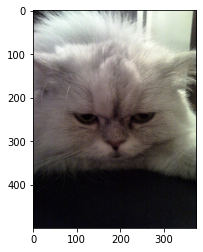

In [9]:
plot_random_image(path_data, depth='*/*')

Файловая система после разделения исходного набора данных на тренировочную, тестовую и валидационную выборки представлена следующим образом:

```
├── data <- папка со всеми наборами данных
│   ├──oxford_pets <- папка с исходным набором данных
│   │   ├── images <- папка с теми же объектами, что за её пределами
│   │   ├── Abyssinian_1.jpg
│   │   ├── Abyssinian_2.jpg
│   │   ├── Abyssinian_3.jpg
│   │   │   
... ... ...
```

Выведение на экран структуры внутренних файлов папки с набором данных:

In [10]:
walk_through_dir(path_data)

Путь: data/oxford_pets -> Каталогов: 1

	├── Класс images -> Изображений: 7392


>Поскольку файлы не разделены по классам на папки и среди них нет файлов с соответствующими лейблами, прежде чем разделять данные на тренировочную, валидационную и тестовую выборки, необходимо сформировать их классы.

---

### 2.2 Формирование классов

Задание функции выведения изображения каждого класса:

In [11]:
def plot_classes_images(data: pd.DataFrame, class_names: list) -> None:
    font_s = 12
    
    n_images = len(class_names)
    fig = plt.figure(figsize=(16, n_images / 2))
    
    cols = 8
    rows = n_images // cols + int((n_images % cols) / 10) + 1
    
    for i, name in enumerate(class_names):
        fig.add_subplot(rows, cols, i+1)
        
        image = data.query('label == @name').sample(1)

        img = Image.open(image['file_path'].item())

        plt.imshow(img)
        plt.axis('off')
        
        plt.title(image['label'].item(), fontsize=font_s+4)
        
        plt.tight_layout()

---

Создание набора данных из путей к каждому изображению:

In [12]:
data = pd.DataFrame(glob.glob(f'{path_data}/*.jpg'), columns=['file_path'])

Преобразование путей:

In [13]:
data['file_path'] = data['file_path'].apply(lambda x: x.replace('\\', '/'))

Выведение первых пяти строк набора данных:

In [14]:
data.head()

,file_path
0,data/oxford_pets/Abyssinian_1.jpg
1,data/oxford_pets/Abyssinian_10.jpg
2,data/oxford_pets/Abyssinian_100.jpg
3,data/oxford_pets/Abyssinian_101.jpg
4,data/oxford_pets/Abyssinian_102.jpg


Добавление столбца с названиями файлов:

In [15]:
data['file_name'] = data['file_path'].str.split(f'{path_data}/').str[1]

Добавление столбца с классами объектов:

In [16]:
data['label'] = data['file_name'].str.rsplit('_').str[0]

Выведение первых пяти строк набора данных для проверки применённых изменений:

In [17]:
data.head()

,file_path,file_name,label
0,data/oxford_pets/Abyssinian_1.jpg,Abyssinian_1.jpg,Abyssinian
1,data/oxford_pets/Abyssinian_10.jpg,Abyssinian_10.jpg,Abyssinian
2,data/oxford_pets/Abyssinian_100.jpg,Abyssinian_100.jpg,Abyssinian
3,data/oxford_pets/Abyssinian_101.jpg,Abyssinian_101.jpg,Abyssinian
4,data/oxford_pets/Abyssinian_102.jpg,Abyssinian_102.jpg,Abyssinian


Сохранение классов объектов:

In [18]:
class_names = data['label'].unique()

Выведение на экран классов объектов:

In [19]:
class_names

array(['Abyssinian', 'american', 'basset', 'beagle', 'Bengal', 'Birman',
       'Bombay', 'boxer', 'British', 'chihuahua', 'Egyptian', 'english',
       'german', 'great', 'havanese', 'japanese', 'keeshond',
       'leonberger', 'Maine', 'miniature', 'newfoundland', 'Persian',
       'pomeranian', 'pug', 'Ragdoll', 'Russian', 'saint', 'samoyed',
       'scottish', 'shiba', 'Siamese', 'Sphynx', 'staffordshire',
       'wheaten', 'yorkshire'], dtype=object)

Выведение изображений каждого класса:

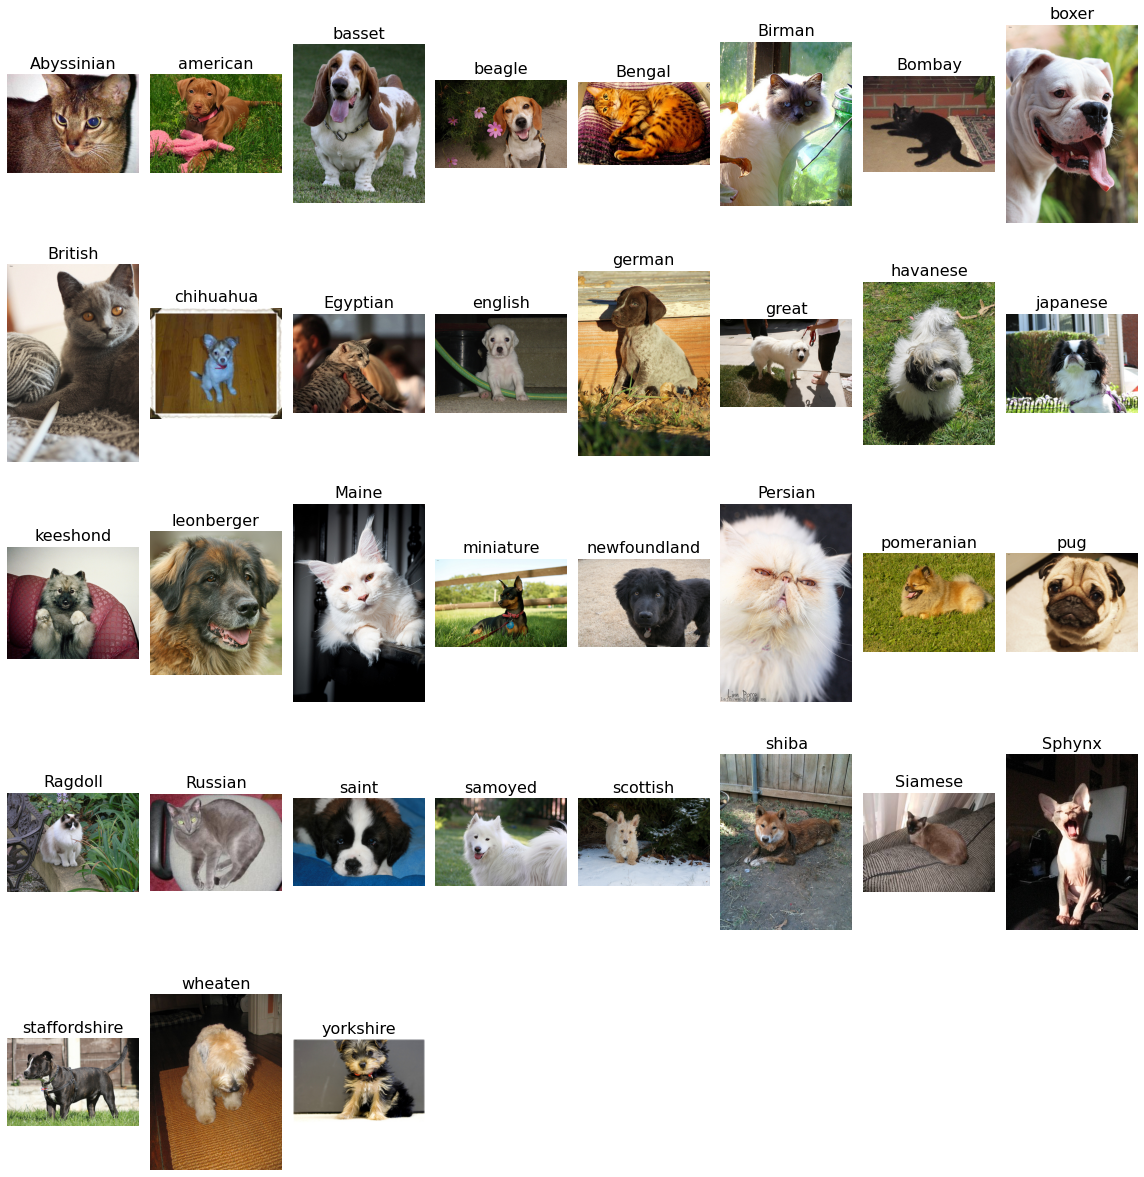

In [20]:
plot_classes_images(data, class_names)

Сохранение пород кошек и собак:

In [21]:
cats = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian', 
        'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx']
dogs = [breed for breed in class_names if breed not in cats]

Выведение на экран общего числа пород кошек и собак:

In [22]:
print('Total cats:', len(cats))
print('Total dogs:', len(dogs))
print('Total breeds:', len(class_names))

Total cats: 12
Total dogs: 23
Total breeds: 35


Сохранение типов животных с классами:

In [23]:
data['label'] = data['label'].apply(lambda x: f'cat_{x}' if x in cats else f'dog_{x}')

Сохранение классов объектов:

In [24]:
class_names = data['label'].unique()

Выведение на экран классов объектов:

In [25]:
class_names

array(['cat_Abyssinian', 'dog_american', 'dog_basset', 'dog_beagle',
       'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'dog_boxer',
       'cat_British', 'dog_chihuahua', 'cat_Egyptian', 'dog_english',
       'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese',
       'dog_keeshond', 'dog_leonberger', 'cat_Maine', 'dog_miniature',
       'dog_newfoundland', 'cat_Persian', 'dog_pomeranian', 'dog_pug',
       'cat_Ragdoll', 'cat_Russian', 'dog_saint', 'dog_samoyed',
       'dog_scottish', 'dog_shiba', 'cat_Siamese', 'cat_Sphynx',
       'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire'], dtype=object)

Выведение на экран общего числа классов и объектов:

In [26]:
print('Total classes:', len(class_names))
print('Total images:', len(data))

Total classes: 35
Total images: 7390


>Были получены классы каждого изображения.

---

### 2.3 Разделение на выборки

Задание функции, разделяющей набор данных на тренировочную и тестовую выборки:

In [27]:
def train_test_split(data: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test_len = int(test_size * len(data))
    
    test = data.sample(test_len)
    train = data.drop(test.index, axis=0) 

    test = test.reset_index(drop=True)
    train = train.reset_index(drop=True)
    
    return train, test

Разделение набора данных на тренировочную, валидационную и тестовую выборки:

In [28]:
train_data_df, test_data_df = train_test_split(data, 0.15)

Выведение на экран размеров полученных выборок:

In [29]:
print('Total images Train:', len(train_data_df))
print('Total images Test:', len(test_data_df))

Total images Train: 6282
Total images Test: 1108


>Набор данных был разделён на тренировочную, валидационную и тестовую выборки.

---

### 2.4 Преобразование в датасет

Задание функции, возвращающей список классов и словарь классов:

In [30]:
def get_classes(files_df: pd.DataFrame) -> Tuple[List[str], Dict[str, int]]:
    
    classes = sorted(files_df['label'].unique())
    class_to_idx = {name: i for i, name in enumerate(classes)}
    
    return classes, class_to_idx

Задание класса формирования кастомного датасета:

In [31]:
class ImageFolderCustom(Dataset):
    
    def __init__(self, 
                 target_dir: str, 
                 files_df: pd.Series,
                 transform: torchvision.transforms.transforms.Compose = None) -> None:
        
        self.files_df = files_df
        self.paths = [list(pathlib.Path(target_dir).glob(name))[0] for name in self.files_df['file_name']]
        self.transform = transform
        self.classes, self.class_to_idx = get_classes(files_df)
        
    def load_image(self, index: int) -> Image.Image:
        '''Open image and return it'''
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')
    
    def __len__(self) -> int:
        '''Return total number of samples'''
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        '''Return data and label of sample'''
        img = self.load_image(index)
        class_name  = self.files_df.iloc[index]['label']
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

---

Задание трансформатора изображений:

In [32]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Формирование тренировочного датасета:

In [33]:
train_data = ImageFolderCustom(path_data, train_data_df, train_transforms)

Выведение на экран результата сравнения размерности тренировочного датасета с его набором данных:

In [34]:
print('Количество объектов в исходном наборе данных совпадает с количеством объектов в кастомном датасете:', 
      len(train_data_df) == len(train_data))

Количество объектов в исходном наборе данных совпадает с количеством объектов в кастомном датасете: True


Выведение на экран изображений из тренировочного датасета:

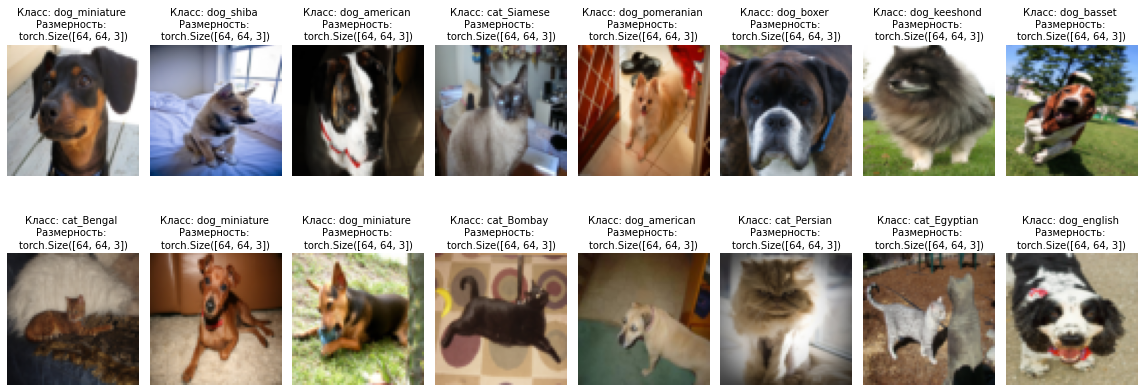

In [35]:
plot_random_dataset_images(train_data, 16)

Формирование загрузчика данных:

In [36]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, 
    batch_size=64,
    shuffle=True
)

Проверка размерности изображения в загрузчике данных:

In [37]:
iterate_dataloader(train_dataloader)

Размерность изображения: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Размерность класса: torch.Size([64])


>Был реализован класс для формирования датасета на основе сформированных ранее наборов данных.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Построение модели

### 3.1 VGG16

Архитектура VGG16 (VisualGeometryGroup с глубиной в 16 слоёв):

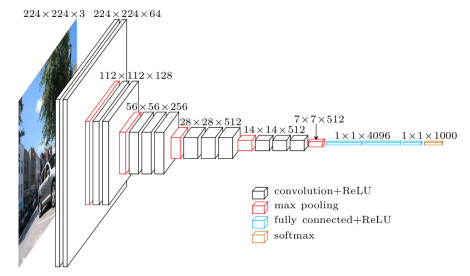

---

#### 3.1.1 Формирование датасетов

Задание констант:

In [38]:
SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Задание трансформаторов изображений:

In [39]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

Формирование датасетов:

In [ ]:
train_data_vgg16 = ImageFolderCustom(path_data, train_data_df, train_transforms)

Выведение на экран изображений из тренировочного датасета:

In [ ]:
plot_random_dataset_images(train_data_vgg16, 16)

Задание констант:

In [ ]:
BATCH_SIZE = 32

Формирование загрузчиков данных:

In [ ]:
train_dataloader_vgg16 = torch.utils.data.DataLoader(
    dataset=train_data_vgg16, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Сохранение названий классов:

In [ ]:
class_names = train_data_vgg16.classes

---

#### 3.1.2 Подготовка модели

Задание нейросети:

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16 = vgg16.to(device)

Выведение на экран слоёв нейросети:

In [ ]:
vgg16

>Необходимо заменить количество выходных значений на общее число классов.

Замена количества выходных значений:

In [ ]:
vgg16.classifier[6].out_features = len(class_names)

Заморозка весов свёрточных слоёв:

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

Выведение на экран информации о послойной обработке данных моделью:

In [ ]:
summary(vgg16)

---

#### 3.1.3 Тестирование модели на одном изображении

Получение значений итерирования по тренировочному датасету:

In [ ]:
imgs, labels = iterate_dataloader(train_dataloader_vgg16, True)

Получение значения одного изображения:

In [ ]:
img_single, label_single = imgs[0].unsqueeze(dim=0), labels[0]

Выведение на экран размерности изображения:

In [ ]:
print(f'Размерность изображения: {img_single.shape}\n')

Перевод модели в режим предсказания и получение результатов предсказаний:

In [ ]:
vgg16.eval()

with torch.inference_mode():
    pred = vgg16(img_single.to(device))

Выведение на экран результатов предсказаний:

In [ ]:
print(f'Результат предсказания: {torch.argmax(torch.softmax(pred, dim=1), dim=1).item()}')
print(f'Настоящий класс: {label_single}')

>Модель выдаёт корректный тип предсказаний.
>
>Но сами предсказания неверные, поскольку модель ещё не обучена.

Выведение на экран подробного описания процесса изменения тензоров по ходу работы модели и информации о модели:

In [ ]:
summary(vgg16, input_size=img_single.shape)

---

#### 3.1.4 Обучение модели

Задание класса обучения:

In [ ]:
class IMGClassifier:
    
    def __init__(self, 
                 model: torch.nn.Module, 
                 device: torch.device,
                 grad_enabled: bool = False) -> None:
        
        self.model = model
        self.device = device
        self.grad_enabled = grad_enabled
        

    def train(self, 
              dataloader: torch.utils.data.DataLoader,
              n_epochs: int,
              criterion: torch.nn.Module,
              optimizer: torch.optim.Optimizer = None,
              scheduler: torch.optim.lr_scheduler.StepLR = None,
              n_batch_check: int = None) -> Tuple[float, float]:
        
        self.dataloader = dataloader
        self.criterion = criterion
        self.__n_batch_check = n_batch_check
        
        self.best_result = {
            'model': self.model.__class__.__name__,
            'loss': 0,
            'accuracy': 0,
        }
        
        self.loss_acc_hist = []
        
        # start timer
        start_time = timer()
        
        for epoch in tqdm(range(n_epochs), 'Training process'):
            # training
            loss, acc, predictions = self.predict(self.dataloader, optimizer)
            self.loss_acc_hist.append([loss, acc])
            
            print(f'\nEpoch [{epoch + 1}/{n_epochs}]   ',
                  f'Loss: {loss:.4f}   ',
                  f'Accuracy: {acc:.4f}\n')
                
            if acc > self.best_result['accuracy']:
                self.best_result['loss'] = loss
                self.best_result['accuracy'] = acc
                self.best_result['predictions'] = predictions
                
        # stop timer
        end_time = timer()
        check_time(start_time, end_time, self.device)
        
        # print best result
        print(f'\nBest loss: {self.best_result["loss"]:.4f}   ',
              f'Best accuracy: {self.best_result["accuracy"]:.4f}\n')
        
        self.loss_acc_hist = np.array(self.loss_acc_hist)
        
        display_confusion_matrix(
            self.best_result['predictions'], 
            dataloader.dataset, 
            self.dataloader.dataset.classes
        )
        
        # plot results
        plot_loss_curves(self.loss_acc_hist[:, 0], self.loss_acc_hist[:, 1])
            
        
    def predict(self, 
                dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer = None,
                scheduler: torch.optim.lr_scheduler.StepLR = None,
                verbose: bool = True) -> Tuple[float, float]:

        self.model.train()
        loss_total, acc_total = 0.0, 0.0
        predictions = []
        
        if dataloader == self.dataloader:
            self.model.train()
        else:
            self.model.eval()
        
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)
            
            loss, acc, y_pred_class = self.forward_backward(dataloader, X, y, optimizer)
            
            loss_total += loss
            acc_total += acc
            predictions.extend(y_pred_class)
            
            if self.__n_batch_check != None and i % self.__n_batch_check == 0 and verbose:
                print(f'Batch [{i}/{len(dataloader)}]   ',
                      f'Loss: {loss:.4f}   ',
                      f'Accuracy: {acc:.4f}')
        
        if scheduler is not None and dataloader == self.dataloader:
            scheduler.step()
        
        loss = loss_total / len(dataloader)
        acc_total = acc_total / len(dataloader)

        return loss_total, acc_total, predictions
    
    
    def forward_backward(self, 
                         dataloader: torch.utils.data.DataLoader, 
                         X: torch.Tensor, 
                         y: torch.Tensor,
                         optimizer: torch.optim.Optimizer) -> Tuple[float, float, torch.Tensor]:
        
        if optimizer is not None:
            optimizer.zero_grad()
            
        # forward
        y_pred = self.model(X)
        
        if self.grad_enabled:
            loss = self.criterion(y_pred, y).clone().detach().requires_grad_(True)
        else:
            loss = self.criterion(y_pred, y)

        # backward
        if dataloader == self.dataloader:
            loss.backward()

            if optimizer is not None:
                optimizer.step()
              
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc = (y_pred_class == y).sum() / len(y_pred_class)
            
        return loss.item(), acc.item(), y_pred_class
    
    
    def get_top(self, n_top: int) -> pd.DataFrame:
        loss_acc_df = pd.DataFrame(
            self.loss_acc_hist,
            columns=['loss', 'accuracy']
        ).sort_values(by='accuracy', ascending=False)

        top = [loss_acc_df.iloc[0]]

        for i in range(len(loss_acc_df)):
            loss_acc = list(loss_acc_df.iloc[i])

            if loss_acc[1] not in np.array(top)[:, 1]:
                top.append(loss_acc)

            if len(top) == n_top:
                display(pd.DataFrame(np.array(top), columns=['loss', 'accuracy']))
                return

Задание функции, формирующей числовые значения целевого признака:

In [ ]:
def get_targets(data: ImageFolderCustom) -> torch.Tensor:
    return torch.IntTensor(data.files_df['label'].apply(lambda x: data.class_to_idx[x]))

Задание функции, выводящей матрицу неточностей:

In [ ]:
def display_confusion_matrix(predictions: List[int],
                             data: ImageFolderCustom,
                             class_names: List[str]) -> None:
    
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(
        preds=torch.IntTensor(predictions), 
        target=get_targets(data)
    )
    
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10,10)
    )

---

Объявление объекта классификатора:

In [ ]:
model_vgg16 = IMGClassifier(vgg16, device)

Задание констант:

In [ ]:
N_EPOCHS = 30
LEARN_R = 0.001

CRITERION = nn.CrossEntropyLoss()
OPTIM = optim.Adam(vgg16.classifier.parameters(), lr=LEARN_R)

Обучение модели:

In [ ]:
model_vgg16.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader_vgg16,
    criterion=CRITERION, 
    optimizer=OPTIM
)

>Модель продемонстрировала хорошую предсказательную способность.

---

### 3.2 ResNet18

Архитектура ResNet18 (Residual Neural Networks с глубиной в 18 слоёв):

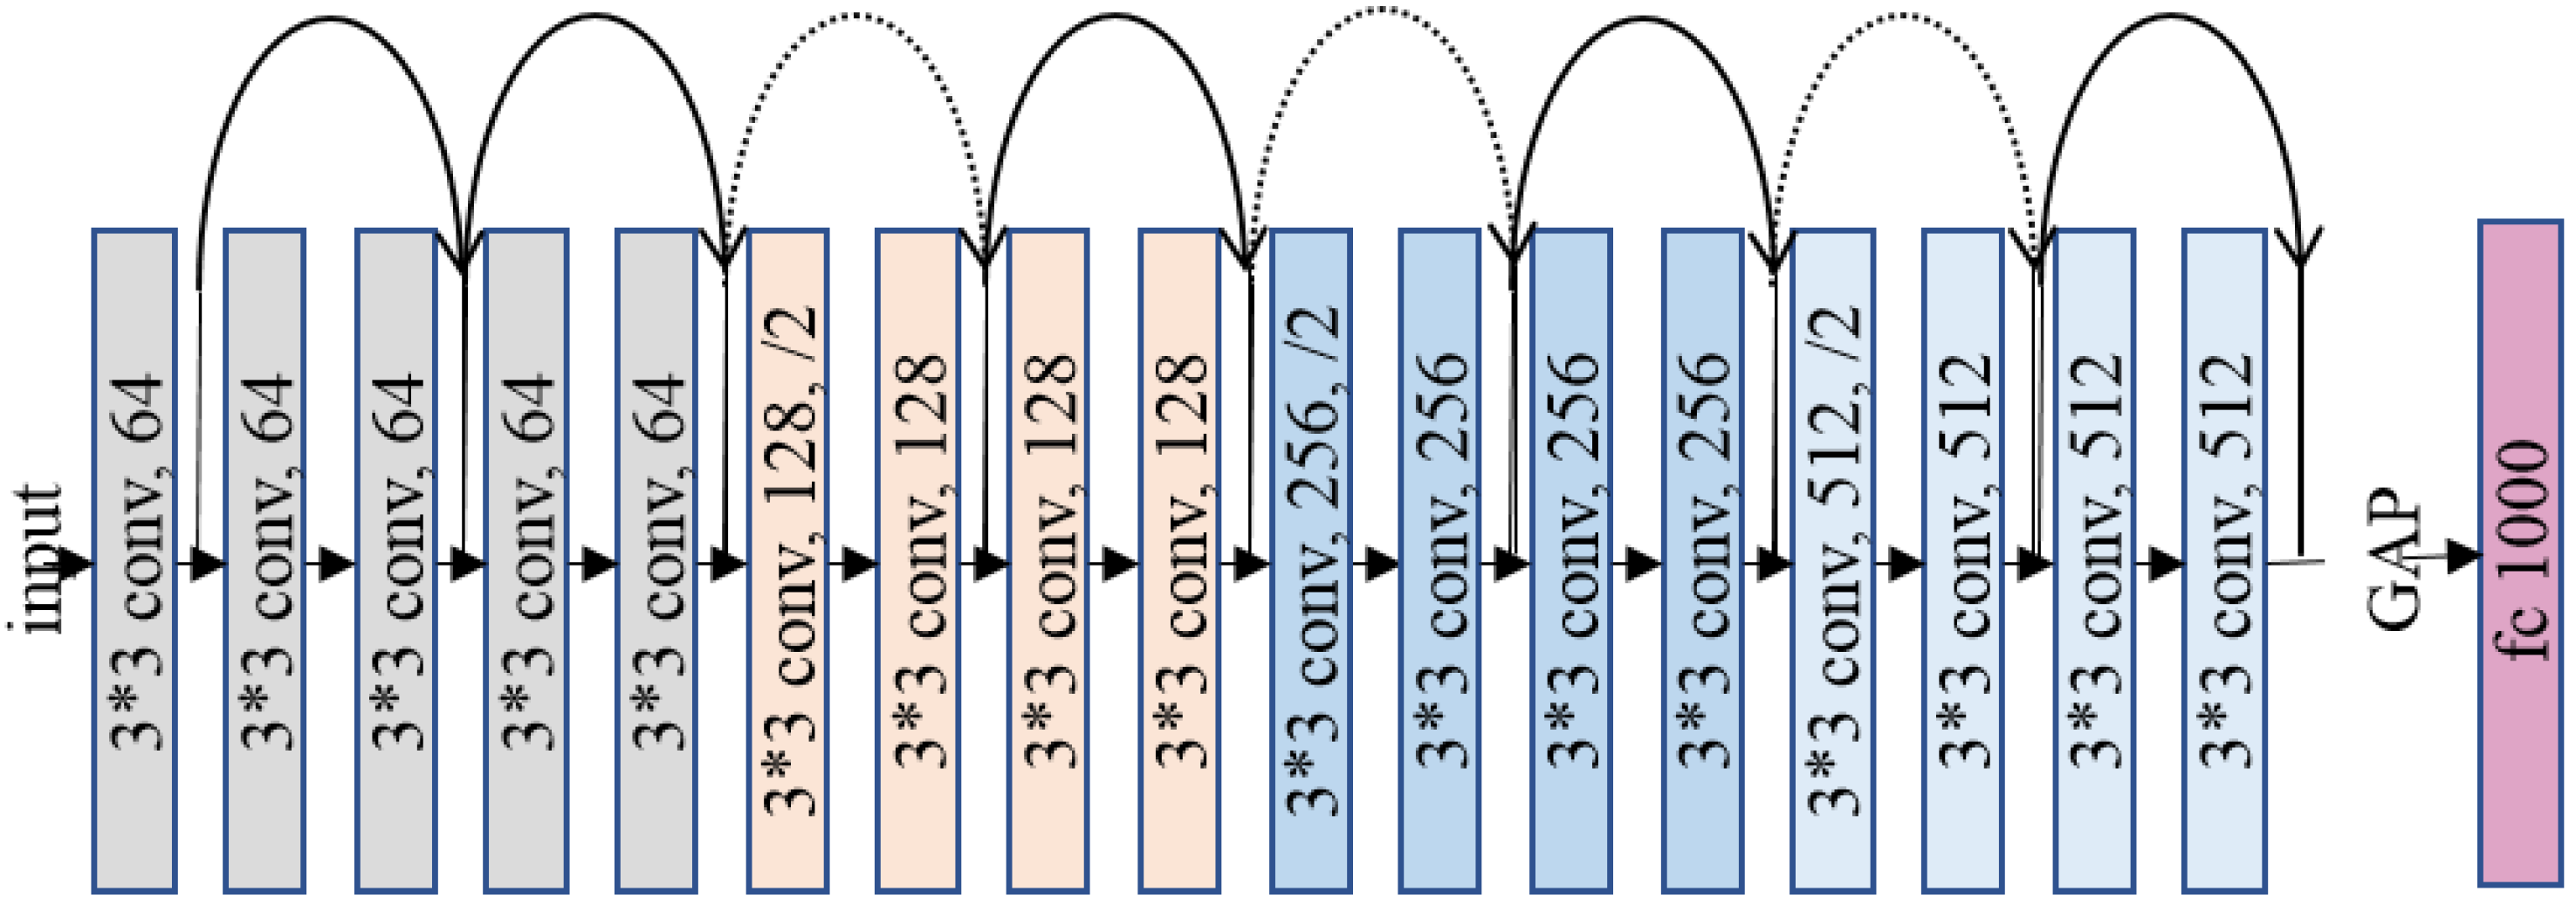

---

#### 3.2.1 Формирование датасетов

In [ ]:
SIZE = 64

Задание трансформаторов изображений:

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

Формирование датасетов:

In [ ]:
train_data_resnet18 = ImageFolderCustom(path_data, train_data_df, train_transforms)

Выведение на экран изображений из тренировочного датасета:

In [ ]:
plot_random_dataset_images(train_data_resnet18, 16)

Задание констант:

In [ ]:
BATCH_SIZE = 4

Формирование загрузчиков данных:

In [ ]:
train_dataloader_resnet18 = torch.utils.data.DataLoader(
    dataset=train_data_resnet18, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Сохранение классов:

In [ ]:
class_names = train_data_resnet18.classes

---

#### 3.2.2 Подготовка модели

Задание нейросети:

In [ ]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

Выведение на экран слоёв нейросети:

In [ ]:
resnet18

>Необходимо заменить количество выходных значений на общее число классов.

Замена количества выходных значений:

In [ ]:
resnet18.fc.out_features = len(class_names)

Заморозка весов свёрточных слоёв:

In [ ]:
for param in resnet18.parameters():
    param.requires_grad = False

Выведение на экран информации о послойной обработке данных моделью:

In [ ]:
summary(resnet18)

---

#### 3.2.3 Тестирование модели на одном изображении

Получение значений итерирования по тренировочному датасету:

In [ ]:
imgs, labels = iterate_dataloader(train_dataloader_resnet18, True)

Получение значения одного изображения:

In [ ]:
img_single, label_single = imgs[0].unsqueeze(dim=0), labels[0]

Выведение на экран размерности изображения:

In [ ]:
print(f'Размерность изображения: {img_single.shape}\n')

Перевод модели в режим предсказания и получение результатов предсказаний:

In [ ]:
resnet18.eval()

with torch.inference_mode():
    pred = resnet18(img_single.to(device))

Выведение на экран результатов предсказаний:

In [ ]:
print(f'Результат предсказания: {torch.argmax(torch.softmax(pred, dim=1), dim=1).item()}')
print(f'Настоящий класс: {label_single}')

>Модель выдаёт корректный тип предсказаний.
>
>Но сами предсказания неверные, поскольку модель ещё не обучена.

Выведение на экран подробного описания процесса изменения тензоров по ходу работы модели и информации о модели:

In [ ]:
summary(resnet18, input_size=img_single.shape)

---

#### 3.2.4 Обучение модели

Объявление объекта классификатора:

In [ ]:
model_resnet18 = IMGClassifier(resnet18, device, True)

Задание констант:

In [ ]:
OPTIM = optim.SGD(resnet18.parameters(), lr=LEARN_R)
SCHEDULER = optim.lr_scheduler.StepLR(OPTIM, step_size=1, gamma=0.1)

Обучение модели:

In [ ]:
model_resnet18.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader_resnet18,
    criterion=CRITERION, 
    optimizer=OPTIM,
    scheduler=SCHEDULER,
    n_batch_check=100
)

>Модель продемонстрировала хорошую предсказательную способность.

---

### 3.3 Сравнение моделей

Построение графиков сравнения метрик моделей на тренировочной выборке:

In [ ]:
plot_loss_curves_comparison(
    model_vgg16.loss_acc_hist, 
    model_resnet18.loss_acc_hist
)

>В качестве модели для тестирования определения класса животных будет взята модель `model_vgg16`.

---

### 3.4 Тестирование модели

Задание функции выведения предсказаний нескольких изображений:

In [ ]:
def plot_image_predictions(model: torch.nn.Module, 
                           device: torch.device,
                           data_df: pd.DataFrame,
                           class_names: List[str] = None, 
                           transform: torchvision.transforms.transforms.Compose = None,
                           n_images: int = 6,
                           depth: str = '*') -> None:
    
    font_s = 12
    cols = 8
    
    if n_images % cols != 0:
        if n_images < cols:
            n_images = cols
        else:
            n_images = (n_images // cols) * cols 
            
        print(f'Для корректной взуализации значение n_images было установлено как кратное {cols}')
        
    image_indexes = list(data_df.sample(n_images).index)
    images = list(data_df['file_path'][image_indexes])
    
    true_labels = list(data_df['label'][image_indexes])
    
    fig = plt.figure(figsize=(16, n_images / 2))
        
    cols = 8
    rows = n_images // cols + int((n_images % cols) / 10)
    
    if rows == 0:
        rows = 1
    
    for i, image in enumerate(images):
        fig.add_subplot(rows, cols, i+1)
        
        img, probs, label = predict_test(image, model, device, transform)
        
        # PyTorch default shape is [C, H, W] but Matplotlib is [H, W, C]
        img_permute = img.squeeze().permute(1, 2, 0)
        
        plt.imshow(img_permute)
        plt.axis('off')
        
        plt.title(f'Прогноз: {class_names[label.cpu()]} \nКласс: {true_labels[i]} \n\nВероятность: {probs.max().cpu():.3f}', 
                  fontsize=font_s-2)
        
        plt.tight_layout()

---

Задание лучшей модели:

In [ ]:
best_model = model_vgg16

Выведение на экран ТОП-3 точности:

In [ ]:
best_model.get_top(3)

Выведение на экран ТОП-5 точности:

In [ ]:
best_model.get_top(5)

Сохранение отчёта по метрикам:

In [ ]:
model_report = get_classification_report(
    get_targets(best_model.dataloader.dataset),
    [pred.item() for pred in best_model.best_result['predictions']],
    class_names
)

Выведение на экран отчёта по метрикам:

In [ ]:
model_report

Выведение на экран общего значения метрик для предсказаний кошек и собак:

In [ ]:
filter_df(model_report, 'cat').join(filter_df(model_report, 'dog'))

Задание трансформаторов изображений:

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224))
])

Получение предсказаний:

In [ ]:
plot_image_predictions(
    model=best_model.model,
    data_df=test_data_df,
    transform=test_transforms,
    class_names=class_names,
    device=device,
    n_images=20
)

>Модель показала хорошую способность к классификации на тестовой выборке.
>
>В подавляющем большинстве случаев предсказания модели совпадают с соответствующими изображениям классами.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>